In [1]:
from scipy import integrate
import sympy as sp
import numpy as np
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)
#from RKSchemes import ImEx_schemes
from Homogenized_system_coefficients import C_values
from Homogenized_system_coefficients import Homogenized_system_coef
fft = np.fft.fft
ifft = np.fft.ifft

In [2]:
import sys

In [3]:
a = lambda y: np.sin(2*np.pi*y)+5
dady= lambda y: 2*np.pi*np.cos(2*np.pi*y)
delta = 0.001
C1, C2, C3, C4, C5, C6, C7, C8, avga,ainvavg = C_values(a=a,dady=dady,delta=delta)

In [4]:
gamma = 1.4 
kappa =1
p_0 = 1
P1 = gamma*kappa*p_0**(gamma-1)
P11= (gamma-1)*gamma*kappa*p_0**(gamma-2)
r1,r2,r3,r4,r5,r6,k1,k2,k3,k4,k5,k6,k7=Homogenized_system_coef(C1,C2,C3,C4,C5,C6,C7,C8,avga,ainvavg,p_0,P1,P11,delta)

In [5]:
L = 2*np.pi; m = 512
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L
A = 0.5
rho0 = p_0 + A*np.exp(-2.36*(x)**2)
q0 = np.zeros_like(rho0)
#u0 = np.zeros(2*m)
rho_ini = rho0+1j*np.zeros_like(rho0)
q_ini  = q0 + 1j*np.zeros_like(q0)
#u0[:m] = rho0; u0[m:] = q0

rhoq_ini = np.array([[rho_ini[i],q_ini[i]] for i in range(q_ini.shape[0])])


omega = (1.0/avga)*(-1j*xi+r6*(1j*xi)**3)
bta = k1*1j*xi
chk = np.ones_like(xi)
l = [[[chk[i],-omega[i]],[-bta[i],chk[i]]] for i in range(len(xi))]
f = np.array([[rho0[i],q0[i]] for i in range(len(x))])
#dtl = -bta+omega
mt = np.array(l)
#lmdamat = [[-(bta/dtl), omega/dtl],[-(1.0/dtl), 1.0/dtl]]
lmdamat = np.linalg.inv(mt)
print(mt.shape, mt.dtype,lmdamat.shape,rhoq_ini.shape,rhoq_ini.dtype)

(512, 2, 2) complex128 (512, 2, 2) (512, 2) complex128


In [6]:
ft = np.zeros_like(f)+1j*np.zeros_like(f)
ft[:,0]=np.fft.fft(f[:,0])
ft[:,1]=np.fft.fft(f[:,1])
bbb = np.squeeze(np.matmul(lmdamat,np.expand_dims(ft,axis=-1)))
bbb.shape

(512, 2)

In [7]:
def rhs_linear(uft,u,xi):
    #Evaluate the linear term
    m = len(xi)
    #rho = u[:m]; q = u[m:];
    rho = u[:,0]
    q = u[:,1]
    v = np.zeros_like(u)
    rhohat = uft[:,0]
    qhat = uft[:,1]
    rhohat = np.real(ifft(1j*xi*rhohat))
    qhat = np.real(ifft(1j*xi*qhat))
    rhs_rho = (1/avga)*(-qhat + r6*np.real(ifft((1j*xi)**3 *fft(q))))
    rhs_q = k1*rhohat
    v[:,0] = rhs_rho; v[:,1] = rhs_q;
    return v

In [8]:
def rhs_nonlinear(u,uft, xi):
    #Evaluate the nonlinear term
    m = len(xi)
    rho = u[:,0]; q = u[:,1];
    v = np.zeros_like(u)
    rhox_f = np.real(ifft(1j*xi*fft(rho))); rh0xx_f = np.real(ifft((1j*xi)**2 *fft(rho)));
    qx_f = np.real(ifft(1j*xi*fft(q))); qxx_f = np.real(ifft((1j*xi)**2 *fft(q)));
    rhohat = fft(rho); qhat = fft(q)
    rhs_rho = (1/avga)*( r1*q*rhox_f + r2*q**2*qx_f + r3*q*rh0xx_f  + \
                       r4*rhox_f*qx_f + r5*rho*q*rhox_f ) + 1.e-16
    rhs_q = k2*q*qx_f + k3*rho*q*qx_f + (k4*q**2 + k5*rho)*rhox_f + k6*qx_f**2 + k7*q*qxx_f + 1.e-16
    v[:,0] = rhs_rho; v[:,1] = rhs_q;
    return v

In [9]:
sys.path.append('/Users/rajvanmp/station_X/pyGP_fields')

In [10]:
from GPE import GPE_scalar_field
from GPE import ImEx
from GPE import GPE_scalar_field_1d2c

In [11]:
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)

In [18]:
def run_HE_example(dt):
    
    T = 1.0 
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames = [rhoq_ini.real]
   
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    rhoq = GPE_scalar_field_1d2c(m,2,rhs_linear,rhs_nonlinear,imx,rhoq_ini)
    
    
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            rhoq.update_stage_sum(k,dt)
            
            rhoq.do_fft(k,lmdamat,dt)
            
            rhoq.update_K(k,xi)
           
            
            
            
        rhoq.sum_contributions(dt)
        
        
        
        t = (n+1)*dt
        

        
        
        if np.mod(n,nplt) == 0:
            frames.append(rhoq.psi.real)
            
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
           # mass = psi_1.calc_mass()+psi_2.calc_mass()
           # mass_err = (mass-mass_ini)/mass_ini
            
          ##  mass_l.append(mass)
           # mass_err_l.append(mass_err)
            
            print("time ",t/tmax)
            


    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
   # mass = psi_1.calc_mass()+psi_2.calc_mass()
    #mass_err = (mass-mass_ini)/mass_ini
            
   # mass_l.append(mass)
   # mass_err_l.append(mass_err)
       
    return frames, mass_l,mass_err_l
    

In [19]:
f1,ml,mel = run_HE_example(0.001)

class shapes (512, 2) (3, 512, 2)
(512, 2) (512, 2)
time  0.001
time  0.021
time  0.041
time  0.061
time  0.081
time  0.101
time  0.121
time  0.14100000000000001
time  0.161
time  0.181
time  0.201
time  0.221
time  0.241
time  0.261
time  0.281
time  0.301
time  0.321
time  0.341
time  0.361
time  0.381
time  0.401
time  0.421
time  0.441
time  0.461
time  0.481
time  0.501
time  0.521
time  0.541
time  0.561
time  0.581
time  0.601
time  0.621
time  0.641
time  0.661
time  0.681
time  0.7010000000000001
time  0.721
time  0.741
time  0.761
time  0.781
time  0.801
time  0.8210000000000001
time  0.841
time  0.861
time  0.881
time  0.901
time  0.921
time  0.9410000000000001
time  0.961
time  0.981


In [21]:
len(f1)

51

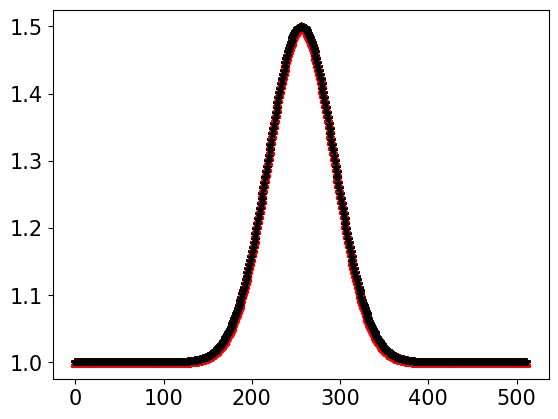

In [42]:
mrk = ("b.","r^","k*","m--")
for i in range(len(f1)):
    ax = plt.subplot()
    j=i%4
    ax.plot(f1[i][:,0],mrk[j],label=str(i))